# Snuffelfiets kwartaalrapportages

## Settings.

In [1]:
# Imports and convenience functions.

from pathlib import Path

import numpy as np
import pandas as pd

from snuffelfiets import inlezen, opschonen, analyse, plotting


def get_period_info(period_spec, year, quarter, month):
    """Return an id-string and the months for the chosen period."""

    quarters = {
        'Q1': [1, 2, 3], 
        'Q2': [4, 5, 6], 
        'Q3': [7, 8, 9], 
        'Q4': [10, 11, 12], 
    }
    periods = {
        'jaar': {
            'period_id': f'{year}',
            'months': list(range(1, 13)),
        },
        'kwartaal': {
            'period_id': f'{year}_{quarter}',
            'months': quarters[quarter],
        },
        'maand': {
            'period_id': f'{year}_{month:02d}',
            'months': [month],
        }
    }
    period_id = periods[period_spec]['period_id']
    months = periods[period_spec]['months']

    return period_id, months


def get_center():
    """Return coordinates for the center of provincie Utrecht."""

    # coordinaten van de uiterste punten van de provincie Utrecht
    b = {
        'N': [52.303634, 5.013507],
        'Z':  [51.858631, 5.040462],
        'O':  [51.954780, 5.627990],
        'W':  [52.226808, 4.794457],
    }

    # het berekende middelpunt van de provincie Utrecht
    center = {
        'lat': b['Z'][0] + 0.5 * (b['N'][0] - b['Z'][0]),
        'lon': b['W'][1] + 0.5 * (b['O'][1] - b['W'][1]),
    }

    return center


def get_layers(data_directory):
    """Import Utrecht province and township polygons"""

    # Download the polygons.
    filepaths = plotting.download_borders_utrecht(data_directory)

    # Extract the relevant polygons.
    provincies, gemeenten = plotting.get_borders_utrecht(data_directory, *filepaths)

    # Enter into dictionary in the mapbox_layers format.
    mapbox_layers = [{
        "name": "Gemeenten",
        "below": 'traces',
        "sourcetype": "geojson",
        "type": "line",
        "color": "gray",
        "source": gemeenten,
        }, 
        {
        "name": "Provincies",
        "below": 'traces',
        "sourcetype": "geojson",
        "type": "line",
        "color": "red",
        "source": provincies,
        }]

    return mapbox_layers


In [2]:
# API settings.
api_key = ''                    # de API key

# File system settings.
prefix = 'api_gegevens'         # de prefix voor de csv-datafiles; default format <prefix>_<yyyy>_<mm>.csv
data_directory = Path(
    Path('~').expanduser(),
    'Documents',
    'MCUdataclub',
    'Snuffelfiets_data',
    'rapportage',
    )                           # het pad naar de folder met de data; dit wordt ook de parent folder van de output


# Date range settings.
period_spec = 'kwartaal'        # de periode waar het rapport over gaat: 'maand', 'kwartaal' of 'jaar'?
year = 2024                     # het jaar waar het rapport over gaat
quarter = 'Q2'                  # het kwartaal waar het rapport over gaat: 'Q1', 'Q2', 'Q3', 'Q4'
month = 6                       # de maand waar het rapport over gaat: 1, 2, 3, ..., 10, 11, 12


# Data processing settings.
error_code_selection = []       # te verwijderen error codes; [] => behoud alleen error_code=0
rit_splitter_interval = 1800    # het interval tussen ritten (s)
ritfilters = dict(
    min_measurements=2,             # #
    max_duration=360,               # minutes
    max_distance=200,               # kilometers
    min_average_speed=1,            # km/h
    max_average_speed=35,           # km/h
    )                           # criteria waaraan ritten moeten voldoen
threshold_pm2_5 = 100           # de cutoff value voor geldige PM2.5 waardes


# Hexbin plot settings.
mapbox_center = get_center()    # het middelpunt van de provincie Utrecht
mapbox_extent = 1               # de breedte rondom de mapbox_center [deg lat/lon]; datapunten buiten deze breedte/lengtegraden worden verwijderd
hexagon_size = 0.010            # de grootte van de hexagons in de hexbin plot
hexbin_args = {
    'agg_func': np.nanmean,
    'color_continuous_scale': plotting.discrete_colorscale(),
    'range_color': [0, threshold_pm2_5],
    'min_count': 2,
    'animation_frame': None,
    'width': 1920,
    'height': 1080,
    'opacity': 1.0,
    'zoom': 10,
    'center': mapbox_center,
    }                           # parameters for creating the hexbin plot
mapbox_layers = get_layers(data_directory)
layout_args = {
    'mapbox_style': 'open-street-map',
    'coloraxis_showscale': False,
    'mapbox_layers': mapbox_layers,
    }                           # parameters for the layout of the hexbin plot

# Directories.
period_id, months = get_period_info(period_spec, year, quarter, month)
Path.mkdir(data_directory, exist_ok=True)
output_directory = Path(data_directory, period_id)
output_directory.mkdir(parents=True, exist_ok=True)

print(f'Analysing {period_spec} {period_id}; writing output to {output_directory}.')


Analysing kwartaal 2024_Q2; writing output to C:\Users\milos\Documents\MCUdataclub\Snuffelfiets_data\rapportage\2024_Q2.


## Read data from monthly CSV's.


In [3]:
# Read the data for the selected period (in monthly chunks).

dfs = []

for m in months:

    filename = f'{prefix}_{year}-{m:02d}.csv'
    p = Path(data_directory, filename)

    try:

        # try to read the data from saved csv's
        df = pd.read_csv(p)

    except FileNotFoundError:

        # download the data if the file does not exist
        inlezen.monthly_csv_dump(api_key, year, month, data_directory, prefix)

        df = pd.read_csv(p)

    dfs.append(df)

df = pd.concat(dfs)

print(f'Read {df.shape[0]} measurements.')


Read 756101 measurements.


## Data preparation

In [4]:
# Get some insight in the error modes present in the dataset.
opschonen.analyse_errors(df)


code          0: count          710195
code         32: count           31155
             32:                        type       : Allowed Error, device maybe indoors
             32:                        description: GPS ERROR 2: No GPS Fix
code        512: count             660
            512:                        type       : Critical Error
            512:                        description: PM ERROR 1: Sensor Not Found
code        533: count            1990
              1:                        type       : Critical Error
              1:                        description: ACCELEROMETER ERROR 1: Sensor Not Found
              4:                        type       : Critical Error
              4:                        description: BME ERROR 1: Sensor Not Found
             16:                        type       : Critical Error
             16:                        description: GPS ERROR 1: Sensor Not Found
            512:                        type       : Critical Err

In [5]:
# Drop the errors.
df = opschonen.verwijder_errors(df, error_codes=error_code_selection)


Removing             660 measurements with error_code             512
Removing           31155 measurements with error_code              32
Removing              33 measurements with error_code             544
Removing           11011 measurements with error_code            2048
Removing             909 measurements with error_code            2080
Removing              99 measurements with error_code            2560
Removing              33 measurements with error_code            2592
Removing               5 measurements with error_code            2088
Removing            1990 measurements with error_code             533
Removing              11 measurements with error_code            2621

Error codes remaining: [0]
Measurements remaining: 710195.


In [6]:
# Convert timestamps to datetime objects and add dt columns.
df = analyse.bewerk_timestamp(df, split=True)


Added ['date_time', 'day', 'week', 'month', 'quarter', 'year'] columns to dataframe.


In [7]:
# Split measurements into rides and add cycle stat columns.
df = analyse.split_in_ritten(df, t_seconden=rit_splitter_interval)


Added ['duur', 'afstand', 'snelheid', 'rit_id'] columns to dataframe.
Identified 4721 rides in the dataset.


In [8]:
# Filter the rides.
df = analyse.filter_ritten(df, **ritfilters)


         9 rides were removed because number of measurements was < 2
        69 rides were removed because duration was >= 360 minutes
         0 rides were removed because distance was >= 200 kilometers
         7 rides were removed because average speed was >= 35 km/h
       646 rides were removed because average speed was < 1 km/h


## Summary Snuffelfiets statistics.

In [9]:
def printfun(period, sumstats):

    print(f'\n==== {period} ====\n')

    print(f"Aantal fietsers: {sumstats['fietsers']['N']}\n")

    print(f"{' ':20} {'totaal':12} {'gemiddeld':12} {'topper':12}")
    print(f'-' * 56)
    stat = 'uren'
    print(f"FIETSTIJD [uur]:  {sumstats[stat]['N']:12f} {sumstats[stat]['G']:12f} {sumstats[stat]['M']:12f}")
    stat = 'afstand'
    print(f"AFSTAND    [km]:  {sumstats[stat]['N']:12f} {sumstats[stat]['G']:12f} {sumstats[stat]['M']:12f}")
    stat = 'ritten'
    print(f"RITTEN      [#]:  {sumstats[stat]['N']:12f} {sumstats[stat]['G']:12f} {sumstats[stat]['M']:12f}")


In [10]:
# Print the summary statistics for the period.
sumstats = analyse.summary_stats(df)
printfun(period_id, sumstats)



==== 2024_Q2 ====

Aantal fietsers: 51

                     totaal       gemiddeld    topper      
--------------------------------------------------------
FIETSTIJD [uur]:   2387.728889    46.818214   159.000000
AFSTAND    [km]:  28502.140467   558.865499  2592.671653
RITTEN      [#]:   3990.000000    78.235294   227.000000


In [35]:
# Print the summary statistics for the months in the quarter.
for m, dfm in df.groupby('month'):
    sumstats = analyse.summary_stats(dfm)
    printfun(f'{year}{m:02d}', sumstats)



==== 202404 ====

Aantal fietsers: 48

                     totaal       gemiddeld    topper      
--------------------------------------------------------
FIETSTIJD [uur]:    742.433889    15.467373    49.000000
AFSTAND    [km]:   8838.828753   184.142266   763.206814
RITTEN      [#]:   1284.000000    26.750000    72.000000

==== 202405 ====

Aantal fietsers: 43

                     totaal       gemiddeld    topper      
--------------------------------------------------------
FIETSTIJD [uur]:    846.843333    19.694031    54.000000
AFSTAND    [km]:   9961.492774   231.662623   900.911421
RITTEN      [#]:   1411.000000    32.813953    85.000000

==== 202406 ====

Aantal fietsers: 40

                     totaal       gemiddeld    topper      
--------------------------------------------------------
FIETSTIJD [uur]:    778.294444    19.457361    56.000000
AFSTAND    [km]:   9466.408445   236.660211  1069.814960
RITTEN      [#]:   1260.000000    31.500000    71.000000


## Air quality evaluation

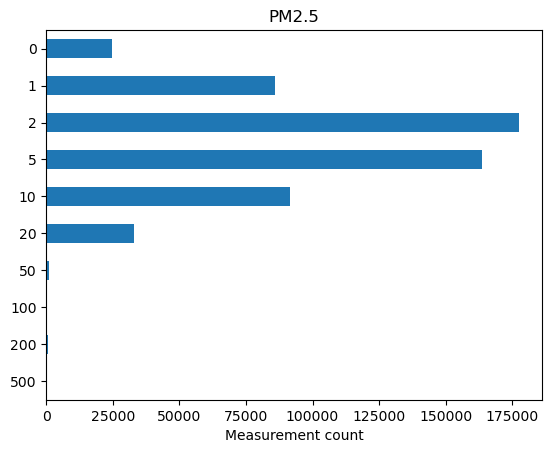

In [11]:
# Plot categorical hist of PM2.5 values.
def plot_hbar_cat(df, bins, labels, title=''):
    df[f'{var}_cat'] = pd.cut(df[var], bins=bins, labels=labels)
    ax = df[['entity_id', f'{var}_cat']].groupby(f'{var}_cat', observed=False).count().plot.barh(stacked=True, legend=False)
    ax.invert_yaxis()
    ax.axes.get_yaxis().get_label().set_visible(False)
    ax.axes.get_xaxis().set_label_text("Measurement count")
    ax.set_title(title)

var = 'pm2_5'
bins = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
labels = [0, 1, 2, 5, 10, 20, 50, 100, 200, 500]
plot_hbar_cat(df, bins, labels, title='PM2.5')


<Axes: >

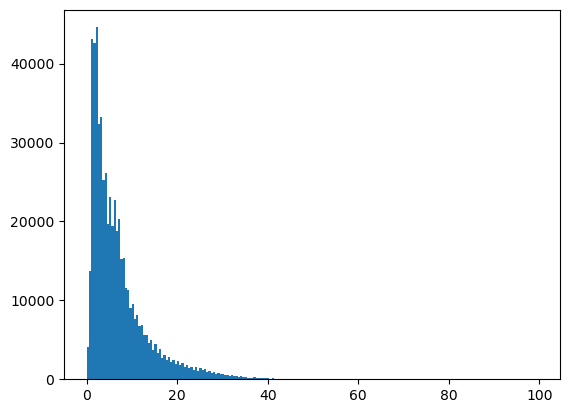

In [12]:
# Limit the PM2.5 values. FIXME: we need a better and validated method
df['pm2_5'][df['pm2_5'] >= threshold_pm2_5] = np.nan

# Plot the histogram.
df['pm2_5'].hist(bins=200, grid=False)


In [13]:
## Hexbin plots of PM2.5

# Remove datapoints outside of the map area 
#   because it would take a very long time to process large areas.
#   TODO: doe dit op ritniveau (verwijderen ritten deels of geheel buiten de target area)
latlon = {
    'latitude': {'center': mapbox_center['lat'], 'extent': mapbox_extent},
    'longitude': {'center': mapbox_center['lon'], 'extent': mapbox_extent},
}
df = opschonen.filter_lat_lon(df, latlon)

# Plot the data for the period.
hexbin_args['title'] = period_id
fig = plotting.hexbin_mapbox(df, hexagon_size, hexbin_args, layout_args)

# Save image
filestem = f'{period_id}_hexbin'
output_stem = Path(output_directory, filestem)
fig.write_html(f"{output_stem}.html")
fig.write_image(f"{output_stem}.png")
fig.write_image(f"{output_stem}.pdf")

# Plot the data for each month.
for m, dfm in df.groupby('month'):

    yyyymm = f'{year}{m:02d}'
    hexbin_args['title'] = yyyymm
    fig = plotting.hexbin_mapbox(dfm, hexagon_size, hexbin_args, layout_args)

    # Save image
    filestem = f'{yyyymm}_hexbin'
    output_stem = Path(output_directory, filestem)
    fig.write_html(f"{output_stem}.html")
    fig.write_image(f"{output_stem}.png")
    fig.write_image(f"{output_stem}.pdf")


c:\Users\milos\miniforge3\envs\snuffelfiets\Lib\site-packages\plotly\figure_factory\_hexbin_mapbox.py:175: RuntimeWarning: Mean of empty slice
  lattice1[i, j] = agg_func(vals)
c:\Users\milos\miniforge3\envs\snuffelfiets\Lib\site-packages\plotly\figure_factory\_hexbin_mapbox.py:182: RuntimeWarning: Mean of empty slice
  lattice2[i, j] = agg_func(vals)
c:\Users\milos\miniforge3\envs\snuffelfiets\Lib\site-packages\plotly\figure_factory\_hexbin_mapbox.py:175: RuntimeWarning:

Mean of empty slice

c:\Users\milos\miniforge3\envs\snuffelfiets\Lib\site-packages\plotly\figure_factory\_hexbin_mapbox.py:182: RuntimeWarning:

Mean of empty slice

c:\Users\milos\miniforge3\envs\snuffelfiets\Lib\site-packages\plotly\figure_factory\_hexbin_mapbox.py:175: RuntimeWarning:

Mean of empty slice

c:\Users\milos\miniforge3\envs\snuffelfiets\Lib\site-packages\plotly\figure_factory\_hexbin_mapbox.py:175: RuntimeWarning:

Mean of empty slice

c:\Users\milos\miniforge3\envs\snuffelfiets\Lib\site-packages\plot

## Uitgelicht 2023-Q1: Fijnstof en regen.

In [14]:
# Specify the date range.
import calendar
lastday = calendar.monthrange(year, months[-1])[1]
dt_min = f'{year}-{months[0]}-1 00:00:00'
dt_max = f'{year}-{months[-1]}-{lastday} 23:59:59'

variables = {
    'RH': 'Etmaalsom van de neerslag [mm]',
    'TG': 'Etmaalgem van de temperatuur [grC]',
    'FG': 'Etmaalgem van de windsnelheid [m/s]',
}

# Import the weather data.
dfr = analyse.import_knmi_data(dt_min, dt_max, interval='dag', stations=[260], variables=variables.keys())
dfr.RH = dfr.RH.values / 10  # RH: Etmaalsom van de neerslag (in 0.1 mm) (-1 voor <0.05 mm)
dfr.TG = dfr.TG.values / 10  # TG: Etmaalgem van de temperatuur (in 0.1 gr C)
dfr.FG = dfr.FG.values / 10  # FG: Etmaalgem van de windsnelheid (in 0.1 m/s)


In [15]:
# Print the monthly pm2.5 average.
df.loc[: , ['month', 'pm2_5']].groupby('month').mean()


,pm2_5
month,
4,3.763287
5,10.957823
6,6.302636


In [16]:
# Print the monthly rainfall sum.
dfr['month'] = dfr.index.month
dfr.loc[: , ['month'] + list(variables.keys())].groupby('month').sum()


,RH,TG,FG
month,,,
4,98.0,322.9,114.9
5,139.7,481.1,84.3
6,56.1,474.1,86.3


In [17]:
# Calculate the mean daily PM2.5 value.
sfday = df.loc[:, ['pm2_5', 'day', 'month', 'year']].groupby(['day', 'month', 'year']).mean()
# Add to the weather data frame.
dfr['pm2_5'] = np.array(sfday['pm2_5'])


In [18]:
# Plot the data.
import matplotlib.pyplot as plt

def plot_knmi_trace(dfr, colname, label=''):

    fig, ax1 = plt.subplots(dpi=300)
    ax2 = ax1.twinx()

    ax1.plot(dfr.index, dfr.pm2_5, c='C1')
    ax2.plot(dfr.index, dfr[colname], c='C0')

    ax1.set_ylabel('PM2.5 [ug/m3]', color='C1')
    ax2.set_ylabel(label, color='C0')

    ax1.plot([dfr.index[0], dfr.index[-1]], [25, 25], c='C1',linestyle='--')
    plt.text(0.86, 0.56, 'norm', c='C1', transform=ax1.transAxes)
    ax1.xaxis.set_tick_params(rotation=45)
    plt.grid(linestyle=':')


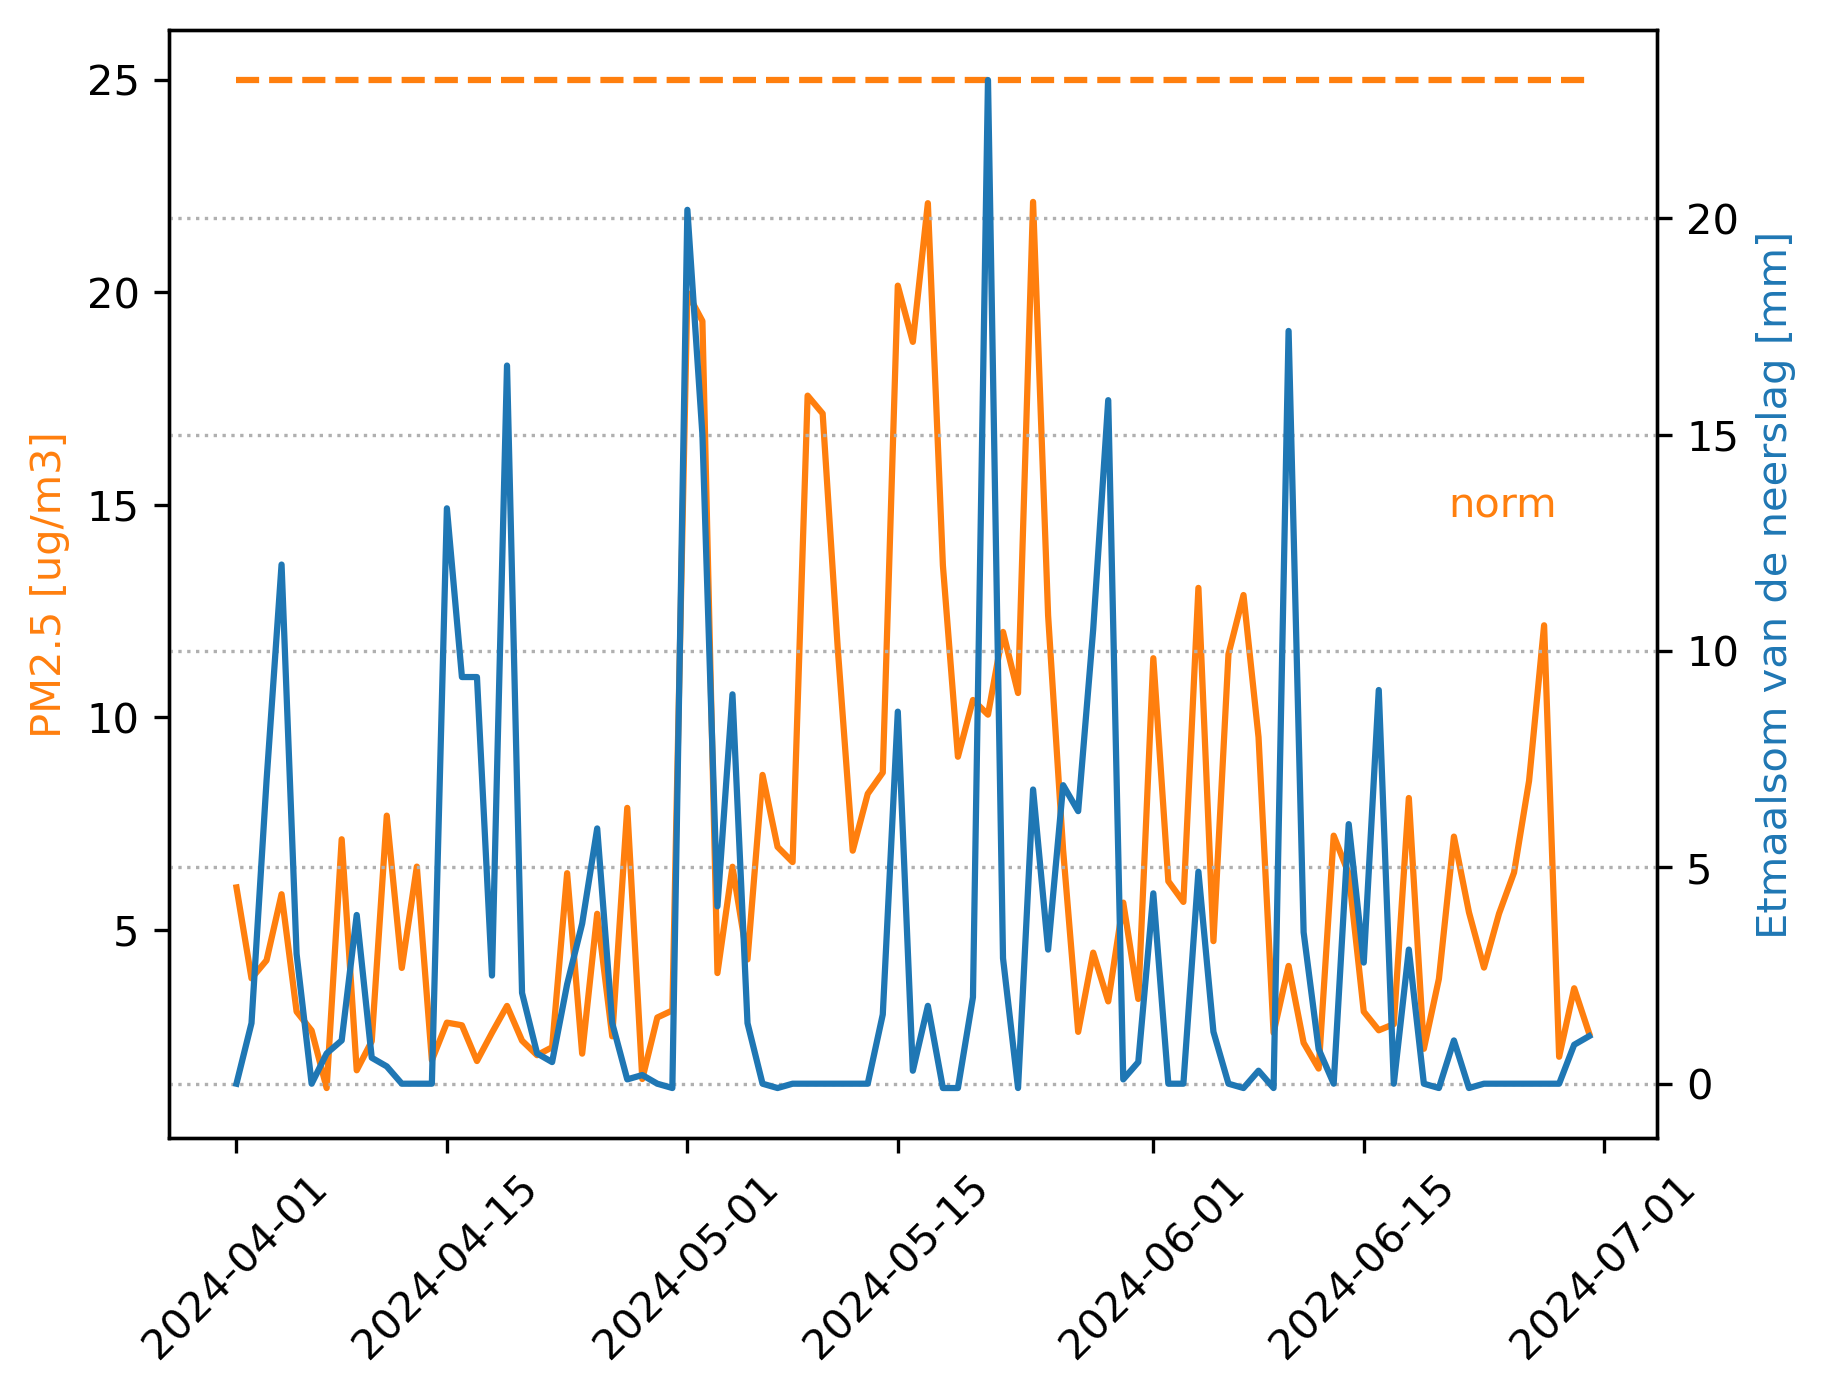

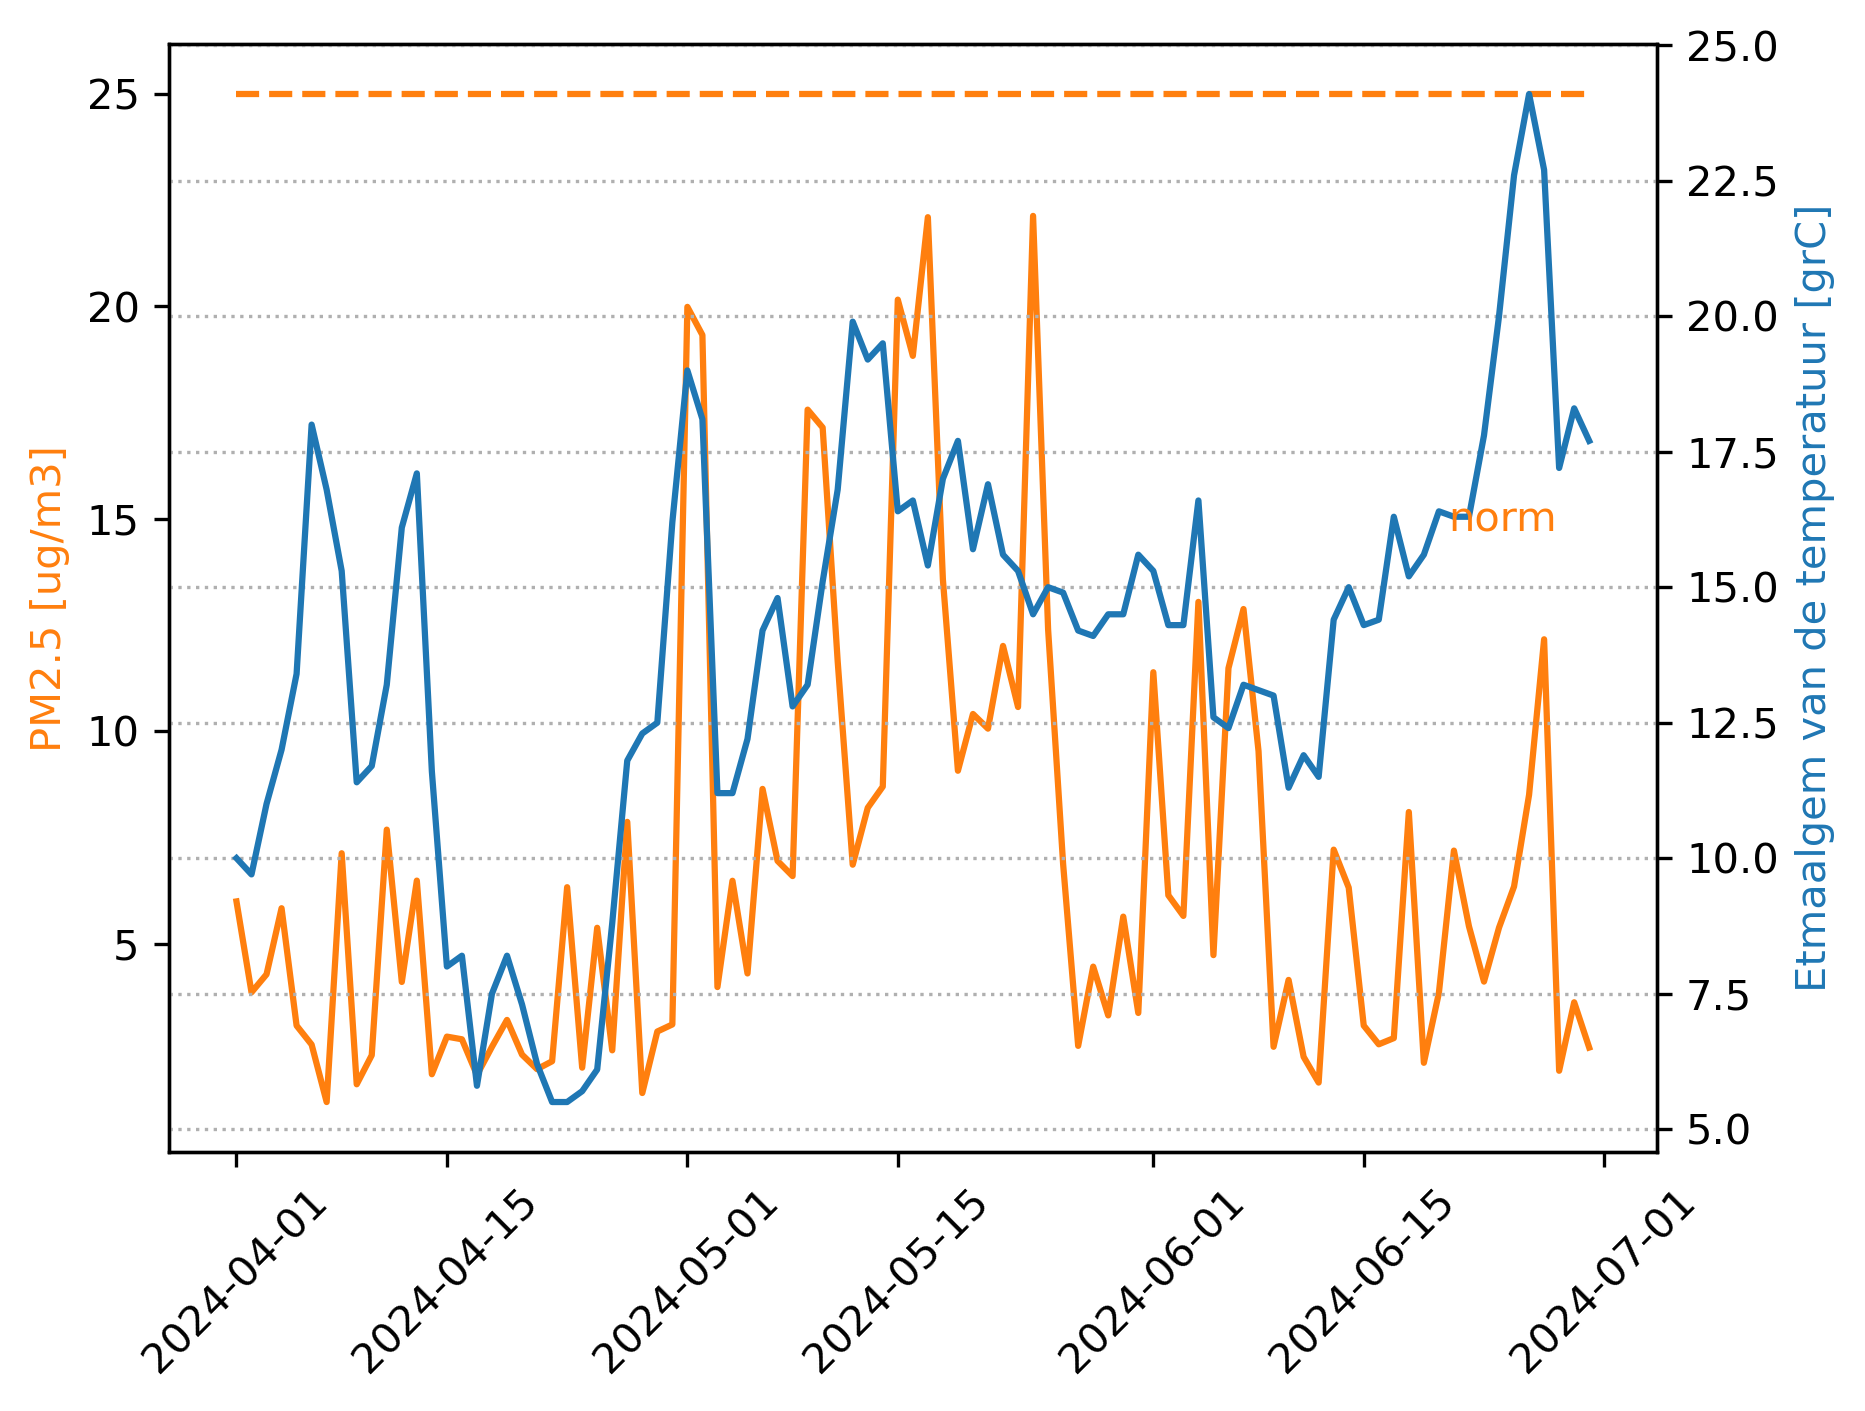

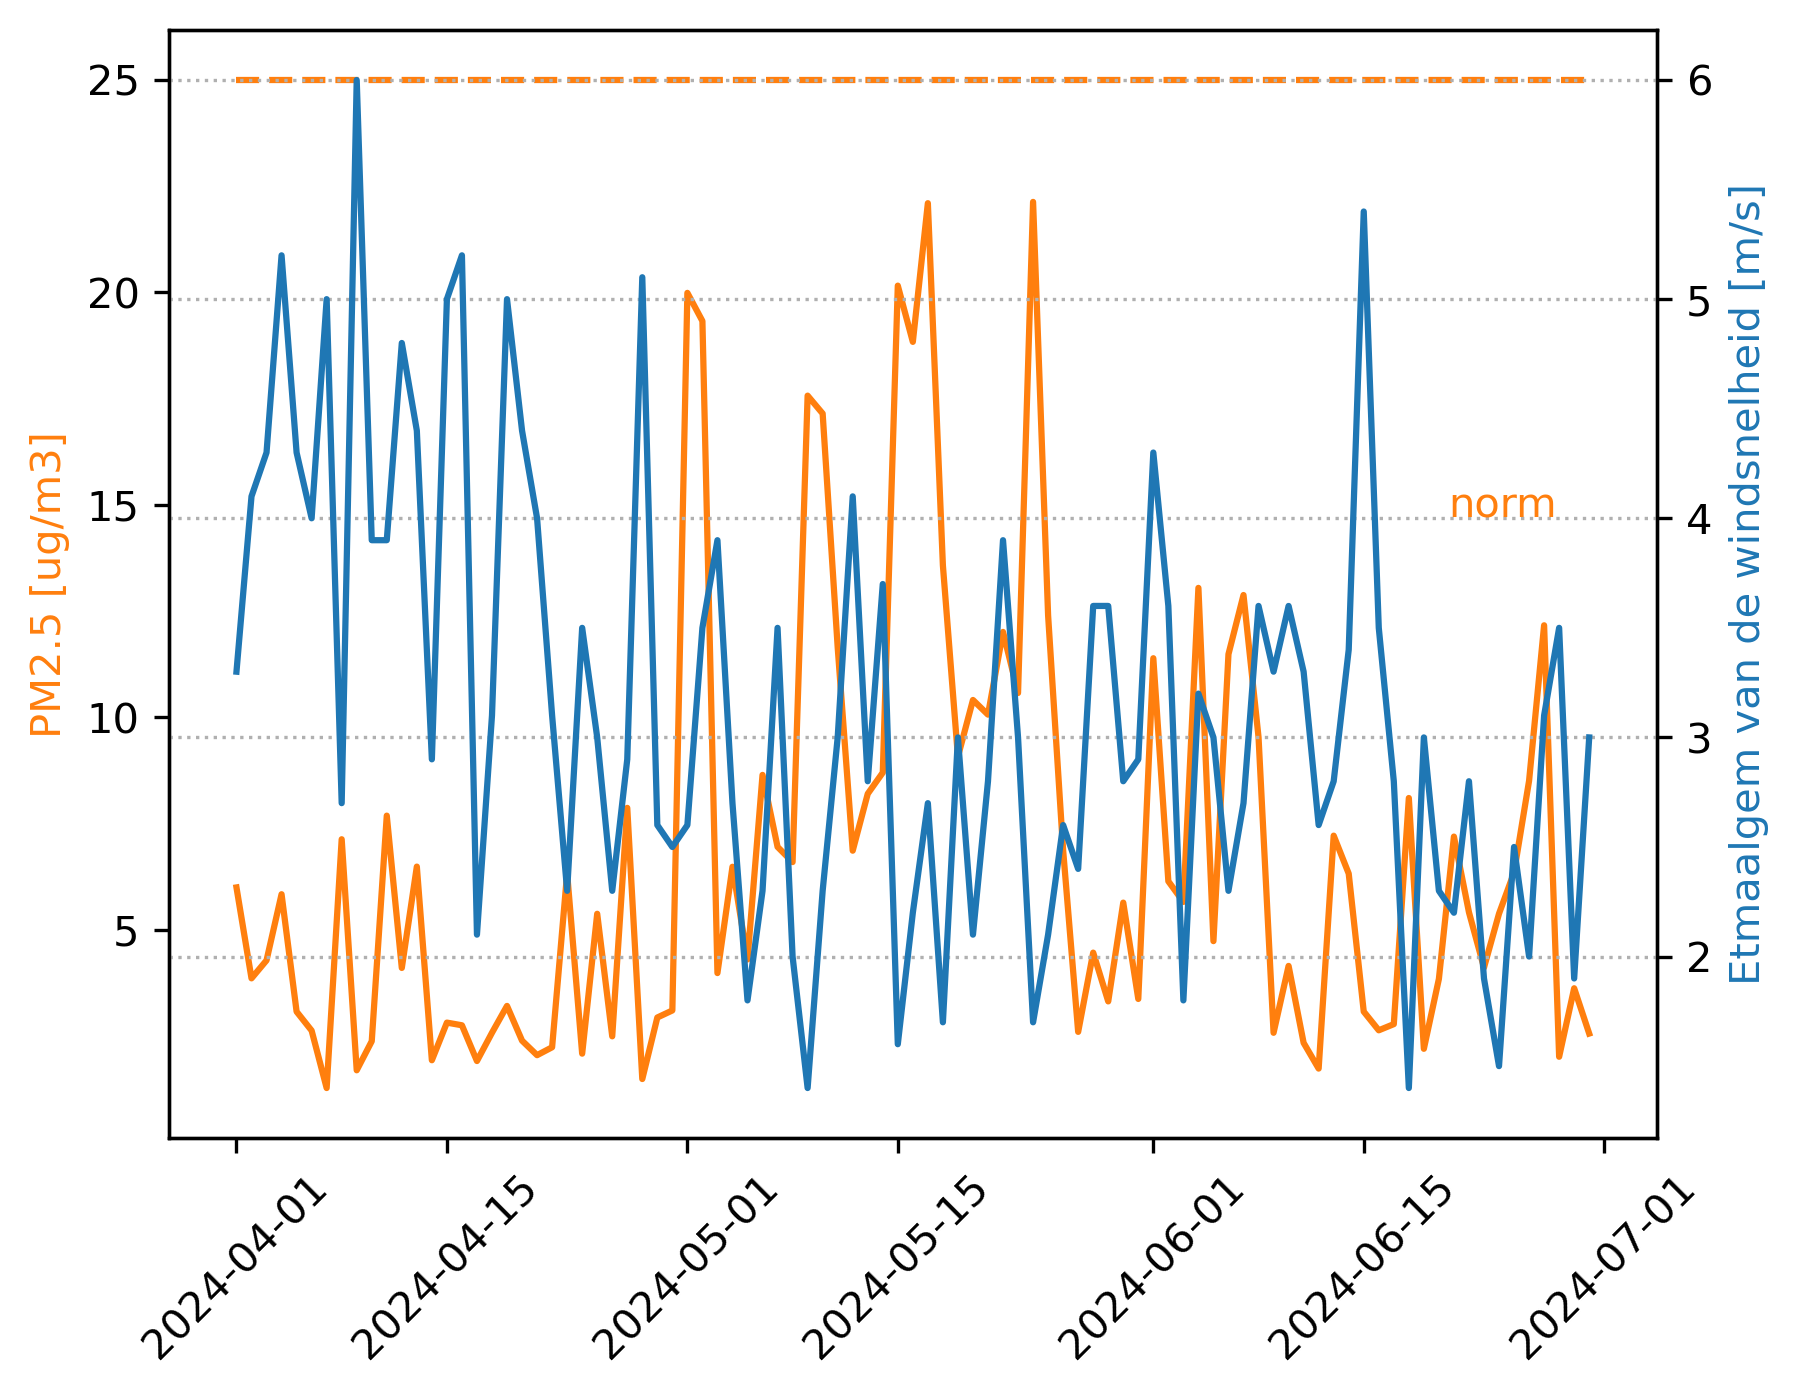

In [19]:
for colname, label in variables.items():
    plot_knmi_trace(dfr, colname, label)

## Uitgelicht 2023-Q2: Fietsgedrag.


In [20]:
# Total number of rides.
Nritten = len(np.unique(df.loc[:,['rit_id']]))


In [21]:
p_dict = {'jaar': ['elk', 'dit'], 'kwartaal': ['elk', 'dit'], 'maand': ['elke', 'deze']}
print(f"We geven jullie {p_dict[period_spec][0]} {period_spec} hiernaast de Toppers, maar niet elk ritje kan uitzonderlijk zijn.")
print(f"We zoomen dit keer in op de {Nritten} ritten die er gemaakt zijn {p_dict[period_spec][0]} {period_spec}.")
print("Hoe ziet zo’n ritje er over het algemeen uit en waar fietsen jullie het meest?")


We geven jullie elk kwartaal hiernaast de Toppers, maar niet elk ritje kan uitzonderlijk zijn.
We zoomen dit keer in op de 3954 ritten die er gemaakt zijn elk kwartaal.
Hoe ziet zo’n ritje er over het algemeen uit en waar fietsen jullie het meest?


In [22]:
# Get aggregated rides dataframe.
options = {
    'rit_id': ['count'],
    'duur':['sum'],
    'afstand': ['sum'],
    'snelheid': ['mean'],
    }
df_ritten = df.groupby(['entity_id', 'rit_id']).agg(options)
df_ritten = df_ritten.reset_index(level=['entity_id', 'rit_id'])
cols = ['entity_id', 'rit_id', 'aantal_waarn', 'duur', 'afstand', 'snelheid_mean']
df_ritten = df_ritten.set_axis(cols, axis=1)
df_ritten


,entity_id,rit_id,aantal_waarn,duur,afstand,snelheid_mean
0,352753092446002,106,48,0 days 00:10:10,1483.450329,2.604435
1,352753092446002,107,61,0 days 00:11:56,2285.708237,3.209214
2,352753092446002,108,23,0 days 00:37:07,216.541503,0.580628
3,352753092446002,109,110,0 days 00:24:21,6823.590492,4.795618
4,352753092446002,110,165,0 days 00:30:39,9147.043606,4.990300
...,...,...,...,...,...,...
3949,359215101869189,4716,29,0 days 00:07:05,1319.038742,4.025277
3950,359215101869189,4717,97,0 days 00:48:09,3774.632829,3.339159
3951,359215101869189,4718,68,0 days 00:17:14,4332.883466,4.353625
3952,359215101929157,4719,77,0 days 00:32:14,8233.359844,2.633507


In [23]:
# Perform unit conversions.
df_ritten['duur_h'] = df_ritten['duur'].dt.total_seconds() / 3600  # h
df_ritten['afstand_km'] = df_ritten['afstand'] / 1000  # km
df_ritten['snelheid_mean_kph'] = df_ritten['snelheid_mean'] / 1000 * 3600 # kph


array([[<Axes: title={'center': 'duur_h'}>,
        <Axes: title={'center': 'afstand_km'}>,
        <Axes: title={'center': 'snelheid_mean_kph'}>]], dtype=object)

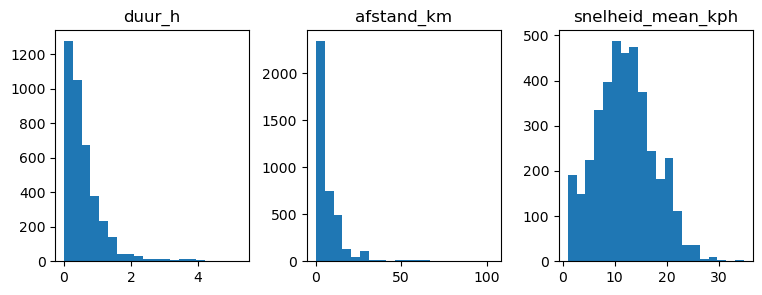

In [24]:
# Plot simple histograms.
df_ritten[['duur_h', 'afstand_km', 'snelheid_mean_kph']].hist(bins=20, grid=False, figsize=(9, 3), layout=(1, 3))


In [25]:
# Duur van de ritten.
Nritten_lang = int(np.sum(df_ritten[['duur_h']] > 4))
Nritten_kort = int(np.sum(df_ritten[['duur_h']] < 5/60))
Pritten_kort = int((Nritten_kort / Nritten) * 100)


c:\Users\milos\miniforge3\envs\snuffelfiets\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

C:\Users\milos\AppData\Local\Temp\ipykernel_10976\3617226356.py:2: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead

c:\Users\milos\miniforge3\envs\snuffelfiets\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

C:\Users\milos\AppData\Local\Temp\ipykernel_10976\3617226356.py:3: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use in

In [26]:
print(f"De meeste ritten zijn korter dan een uur.")
print(f"Een klein deel ({Pritten_kort}%) is zelfs korter dan 5 minuten.")
print(f"{Nritten_lang} ritten waren langer dan 4 uur.")


De meeste ritten zijn korter dan een uur.
Een klein deel (7%) is zelfs korter dan 5 minuten.
18 ritten waren langer dan 4 uur.


In [27]:
# Afstand van de ritten.
Nritten_dichtbij = int(np.sum(df_ritten[['afstand_km']] < 5))
Pritten_dichtbij = int((Nritten_dichtbij / Nritten) * 100)

far = df_ritten.loc[df_ritten['afstand_km'] > 20]
far.describe()


c:\Users\milos\miniforge3\envs\snuffelfiets\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

C:\Users\milos\AppData\Local\Temp\ipykernel_10976\2516491098.py:2: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead



,entity_id,rit_id,aantal_waarn,duur,afstand,snelheid_mean,duur_h,afstand_km,snelheid_mean_kph
count,2.480000e+02,248.000000,248.000000,248,248.000000,248.000000,248.000000,248.000000,248.000000
mean,3.568367e+14,2077.233871,558.459677,0 days 02:08:16,36937.319959,5.468298,2.137876,36.937320,19.685874
std,8.853234e+11,1022.562991,248.834771,0 days 01:05:29,17376.494212,0.967673,1.091599,17.376494,3.483623
min,3.527531e+14,305.000000,143.000000,0 days 00:50:05,20168.012113,2.789685,0.834722,20.168012,10.042867
25%,3.567261e+14,1229.000000,396.000000,0 days 01:18:21,26894.166834,5.210705,1.305903,26.894167,18.758538
50%,3.567261e+14,1620.000000,429.000000,0 days 01:36:40,27878.157568,5.658854,1.611250,27.878158,20.371873
75%,3.567261e+14,3027.250000,718.500000,0 days 02:52:20,47715.073298,5.922414,2.872292,47.715073,21.320689
max,3.592151e+14,4633.000000,1499.000000,0 days 05:14:54,103160.290750,9.662619,5.248333,103.160291,34.785429


In [28]:
print(f"Lokale ritjes lijken dan ook het populairst: meer dan de helft ({Pritten_dichtbij}%) is korter dan 5 kilometer.")


Lokale ritjes lijken dan ook het populairst: meer dan de helft (58%) is korter dan 5 kilometer.


In [29]:
# Snelheid van de ritten.
fast = df_ritten.loc[df_ritten['snelheid_mean_kph'] > 25]
Nritten_fast = int(np.sum(df_ritten[['duur_h']] > 4))
fast_and_far = fast.loc[fast['afstand_km'] > 20]
Pfast_and_far = int((fast_and_far.shape[0] / fast.shape[0]) * 100)

slow = df_ritten.loc[df_ritten['snelheid_mean_kph'] < 5]


c:\Users\milos\miniforge3\envs\snuffelfiets\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning:

The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)

C:\Users\milos\AppData\Local\Temp\ipykernel_10976\658265937.py:3: FutureWarning:

Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead



In [30]:
print("Er is best wat variatie in de snelheid die gefietst wordt.")
print(f"{fast.shape[0]} ritten bereikten een gemiddelde snelheid hoger dan 25 km/u.")
print(f"Het merendeel ({Pfast_and_far}%) hiervan waren langere ritten van meer dan 20 km!")
print(f"Relaxte ritjes (< 5 km/u) waren er ook genoeg. In {slow.shape[0]} ritjes werd gemiddeld {np.mean(slow['afstand_km']):.1f} km afgelegd.")


Er is best wat variatie in de snelheid die gefietst wordt.
44 ritten bereikten een gemiddelde snelheid hoger dan 25 km/u.
Het merendeel (27%) hiervan waren langere ritten van meer dan 20 km!
Relaxte ritjes (< 5 km/u) waren er ook genoeg. In 415 ritjes werd gemiddeld 0.7 km afgelegd.


Text(0.5, 0, 'Aantal ritten')

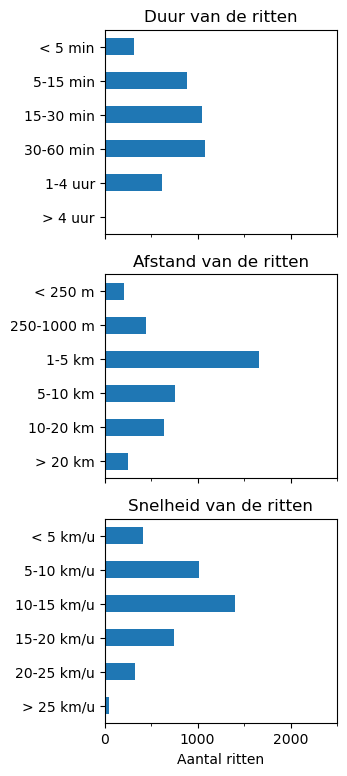

In [31]:
# Plot categorical graphs.

p_dict = {'jaar': [0, 10000, 2500], 'kwartaal': [0, 2500, 1000], 'maand': [0, 1000, 250]}

def plot_hbar_cat(ax, df, bins, labels, title='', xslc=p_dict[period_spec]):
    df[f'{var}_cat'] = pd.cut(df[var], bins=bins, labels=labels)
    ax = df[['entity_id', f'{var}_cat']].groupby(f'{var}_cat', observed=False).count().plot.barh(stacked=True, legend=False, ax=ax)
    ax.invert_yaxis()
    ax.axes.get_yaxis().get_label().set_visible(False)
    # ax.axes.get_xaxis().set_label_text("Aantal ritten")
    ax.set_xlim(xslc[0], xslc[1])
    ax.set_xticks(range(xslc[0], xslc[1], xslc[2]))
    ax.set_title(title)

import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 1, figsize=(3, 9), sharex=True)

var = 'duur_h'
bins = [0.00, 0.0833, 0.25, 0.50, 1.00, 4.00, np.inf]
labels = ['< 5 min', '5-15 min', '15-30 min', '30-60 min', '1-4 uur', '> 4 uur']
plot_hbar_cat(axs[0], df_ritten, bins, labels, title='Duur van de ritten')

var = 'afstand_km'
bins = [0.00, 0.25, 1.00, 5.00, 10.00, 20.00, np.inf]
labels = ['< 250 m', '250-1000 m', '1-5 km', '5-10 km', '10-20 km', '> 20 km']
plot_hbar_cat(axs[1], df_ritten, bins, labels, title='Afstand van de ritten')

var = 'snelheid_mean_kph'
bins = [0.00, 5.00, 10.00, 15.00, 20.00, 25.00, np.inf]
labels = ['< 5 km/u', '5-10 km/u', '10-15 km/u', '15-20 km/u', '20-25 km/u', '> 25 km/u']
plot_hbar_cat(axs[2], df_ritten, bins, labels, title='Snelheid van de ritten')

axs[2].axes.get_xaxis().set_label_text("Aantal ritten")


In [32]:
# Remove datapoints outside of the map area 
#   because it would take a very long time to process large areas.
#   TODO: doe dit op ritniveau (verwijderen ritten deels of geheel buiten de target area)
latlon = {
    'latitude': {'center': mapbox_center['lat'], 'extent': mapbox_extent},
    'longitude': {'center': mapbox_center['lon'], 'extent': mapbox_extent},
}
df = opschonen.filter_lat_lon(df, latlon)


In [33]:
# Identify a nice colormap.
import plotly.express as px
fig = px.colors.sequential.swatches_continuous()
fig.show()

# => Simple jet may be best


In [34]:
# Count measurement, rides and users in a hexbin.

import plotly.figure_factory as ff


# agg function to count unique rides and users in the honeycomb.
def n_unique(x):
    return(len(np.unique(x)))

# shared arguments
hexbin_args = {
    'data_frame': df,
    'lat': 'latitude',
    'lon': 'longitude',
    'color_continuous_scale': 'jet',  # bluered
    'min_count': 1,
    'animation_frame': None,
    'width': 1920,
    'height': 1080,
    'opacity': 0.3,
    'zoom': 10,
    'center': mapbox_center,
    'show_original_data': False,
    'labels': {'color': 'N'}, 
    }
layout_args = {
    'mapbox_style': 'open-street-map',
    'coloraxis_showscale': True,
    'mapbox_layers': mapbox_layers,
    'margin': dict(b=0, t=0, l=0, r=0),
    }

# specific arguments
pars = {
    'counts': {
        'color': None,
        'agg_func': None,
        'labels': {'color': 'N'},
        'range_color': [0, 2000],
        },
    'rides': {
        'color': 'rit_id',
        'agg_func': n_unique,
        'labels': {'color': 'ritten'},
        'range_color': [0, 150],
        },
    'users': {
        'color': 'entity_id',
        'agg_func': n_unique,
        'labels': None,
        'range_color': [0, 10],
        },
}

for k, par in pars.items():

    # Replace keys.
    hexbin_args = {**hexbin_args, **par}

    # Plot the data for each month.
    hexbin_args['title'] = period_id
    hexbin_args['nx_hexagon'] = np.ceil(
        (df['longitude'].max() - df['longitude'].min()) / hexagon_size,
        ).astype('int')
    fig = ff.create_hexbin_mapbox(**hexbin_args)
    fig.update_layout(**layout_args)
    fig.update_coloraxes(colorbar_tickfont_size=35)

    # Save image
    filestem = f'{period_id}_hexbin_{k}'
    output_stem = Path(output_directory, filestem)
    fig.write_html(f"{output_stem}.html")
    fig.write_image(f"{output_stem}.png")
    fig.write_image(f"{output_stem}.pdf")
